In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
%matplotlib inline
from scipy.stats import ttest_1samp
%run ./master_experminet-functions.ipynb

In [27]:
def quick_sort(df):
    sorted_df = df.sort_values(kind="quicksort")
    return sorted_df
def merge_sort(df):
    sorted_df = df.sort_values(kind="mergesort")
    return sorted_df
def heap_sort(df):
    sorted_df = df.sort_values(kind="heapsort")
    return sorted_df

In [131]:
n_samples = 100000
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf"]
list_distributions = 1000*["Uniform"]  + 1000*["Uniform_Sorted"]
#list_distributions = 500*["Uniform"] + 500*["Normal"]+ 500*["Uniform_Sorted"]+500*["Uniform_Reverse_Sorted"]
list_distributions_1 = 2000*["Uniform"] + 2000*["Normal"]
list_distributions_2 = 500*["Uniform_Sorted"]+500*["Uniform_Reverse_Sorted"]

In [132]:
def plot_history(rewards,cum_rewards,chosen_arms ):

    fig = plt.figure(figsize=[30,8])

    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards")
    labels = list(chosen_arms.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar([i for i in range(len(chosen_arms.values()))], chosen_arms.values(), label=[i for i in ((list(chosen_arms.keys())))])
    ax3.set_title("Chosen Actions")
    


# Upper Confidence Bound

In [133]:
def plot_history_2(rewards,cum_rewards,sample_count, sample_mean):

    q_values = {"quick_sort": sample_mean[0], "merge_sort": sample_mean[1], "heap_sort":sample_mean[2]} ## 
    arm_counts = {"quick_sort": sample_count[0], "merge_sort": sample_count[1], "heap_sort":sample_count[2]} ##
    print("Average rewards per algo", q_values)
    print("Count per chosen algo", arm_counts)
    
    fig = plt.figure(figsize=[30,8])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards")
    labels = list(arm_counts.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar([i for i in range(len(arm_counts.values()))], arm_counts.values(), label=[i for i in ((list(arm_counts.keys())))])
    ax3.set_title("Chosen Actions")
    plt.show() 

In [134]:
# help function to return the humber of consecutive elements in a list 
def count_consec(listrand):
    count=1
    consec_list=[]
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)     

    return consec_list

In [135]:
total_reward = 0
arm_rewards = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
q_values = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
rewards = []
cum_rewards = []
num_choices = len(choices)
sample_count = [0 for i in range(num_choices)]
sample_rewards = [0 for i in range(num_choices)]
sample_mean = [0.0 for i in range(num_choices)]
sample_var = [0.0 for i in range(num_choices)]
arm_rewards = {0: [], 1:[], 2:[]}
ucb_values = [0.0 for i in range(num_choices)]
list_iteration_results = []
bound_const = 0.001
p_val_multiplier = 10
n_consecutive_list = []
num_consec_elem = 5
iter_num = 0

for n, elem in enumerate(list_distributions):
    dist_type = elem
    distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
    #print("\n")
    #print("Round:", n)
    for i in range(num_choices):
        if sample_count[i] > 0: 
            average_reward = sample_mean[i]
            #print("av_reward", average_reward, "for", choices_names[i])
            delta_i = bound_const*math.sqrt(2 * math.log(iter_num) / sample_count[i])
            #print("delta_i", delta_i, "for", choices_names[i])
            ucb_values[i] = average_reward + delta_i
        elif sample_count[i] == 0:
            ucb_values[i] = 1e500
    #print(ucb_values)
    choice = np.argmax(ucb_values)
    
    alg = choices[choice]
    alg_name = choices_names[choice]
    start_time = time.perf_counter()
    sorted_dist = alg(distribion[dist_type])
    reward = (time.perf_counter() - start_time)*(-1)
    #print("Chosen algorithm is: ", alg, "with reward:", reward)
    arm_rewards[choice].append(reward)
    sample_count[choice] += 1
    sample_rewards[choice] += reward
    sample_mean[choice] = np.mean(arm_rewards[choice])
    #sample_mean[choice]+= (1/sample_count[choice])*(reward-sample_mean[choice])
    sample_var[choice] = np.var(arm_rewards[choice])
    total_reward += reward
    rewards.append(reward)
    cum_rewards.append(sum(rewards)/len(rewards))
    iter_num += 1
    tset, pval = ttest_1samp(arm_rewards[choice], reward)
    #print("\n")
    #print("p-value: ", pval)
    #print("Significance level: ", (sample_var[choice]**p_val_multiplier))

    
    if pval < sample_var[choice]**p_val_multiplier:
            n_consecutive_list.append(n)
            if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    #print("RESTART EXPERIMENT AT ITERATION:", n)

                    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
                    sample_count = [0 for i in range(num_choices)]
                    sample_rewards = [0 for i in range(num_choices)]
                    sample_mean = [0.0 for i in range(num_choices)]
                    sample_var = [0.0 for i in range(num_choices)]
                    arm_rewards = {0: [], 1:[], 2:[]}
                    rewards = []
                    cum_rewards = []
                    n_consecutive_list = []
                    iter_num = 0

    
list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])


C:\Users\iRacheva\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\iRacheva\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\iRacheva\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\iRacheva\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\iRacheva\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Iteration 1004
Average rewards per algo {'quick_sort': -0.01198410639535864, 'merge_sort': -0.01355441229510629, 'heap_sort': -0.021278600001096493}
Count per chosen algo {'quick_sort': 516, 'merge_sort': 488, 'heap_sort': 1}


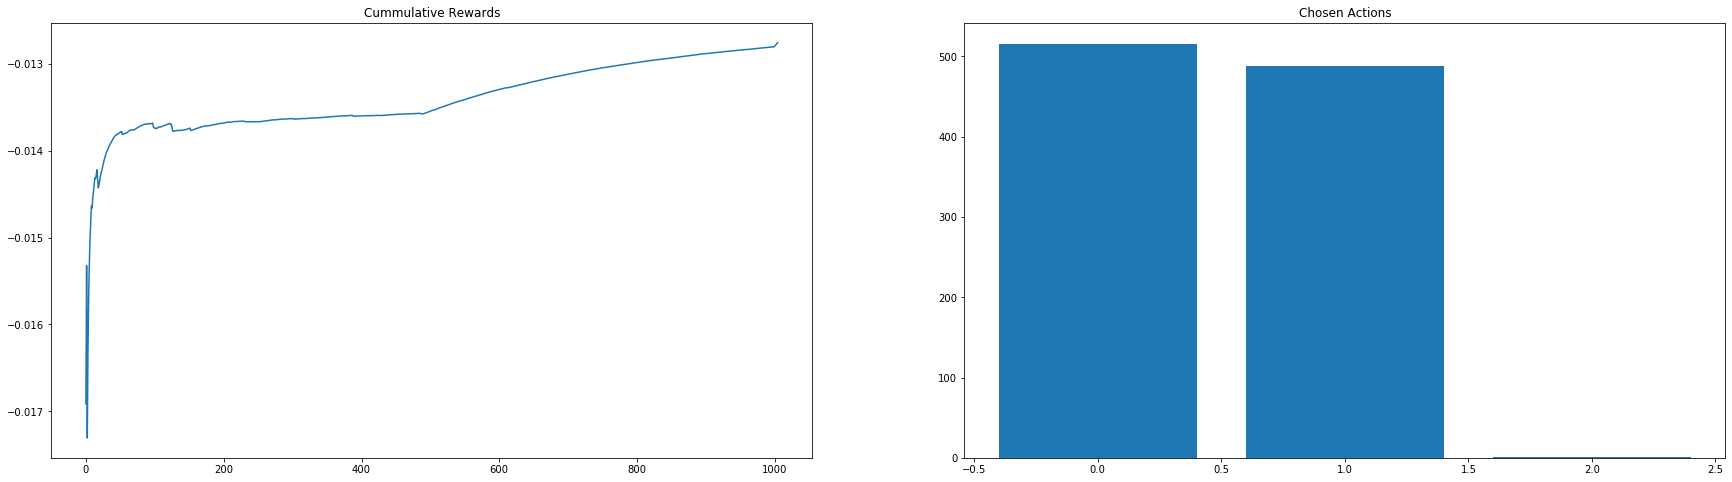

Iteration 1999
Average rewards per algo {'quick_sort': -0.0037907750001977547, 'merge_sort': -0.0025695947262304544, 'heap_sort': -0.009357099999760976}
Count per chosen algo {'quick_sort': 8, 'merge_sort': 986, 'heap_sort': 1}


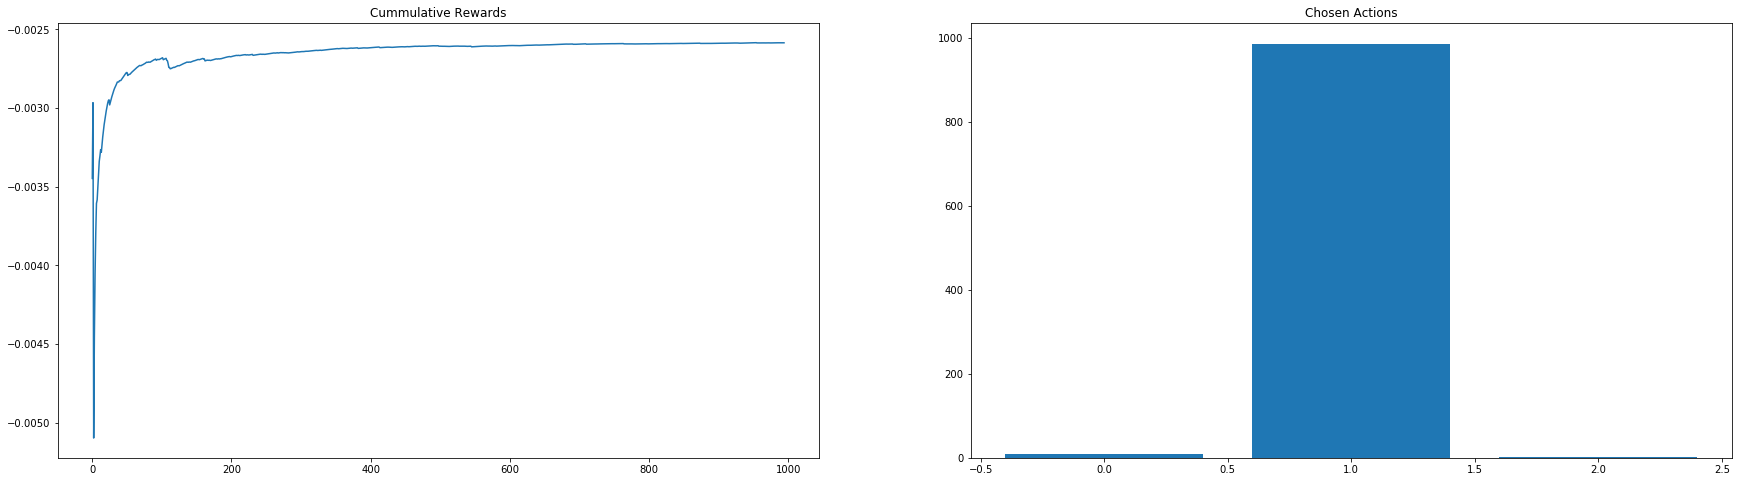

Total reward -15.3929


In [136]:
for elem in list_iteration_results:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Iteration", n)
    plot_history_2(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward,4))